In [1]:
# Business Impact Analysis - Churn Prediction
# Quantifying the business value and ROI of the ML model

# Step 1: Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from src.preprocessing import load_data, split_data
from src.modeling import load_model
from src.config import BEST_MODEL_FILE

sns.set_style("whitegrid")
print("✅ Setup complete")


⚠️ LightGBM not available
✅ Setup complete


In [2]:
# Step 2: Define Business Parameters
print("="*70)
print("BUSINESS PARAMETERS")
print("="*70)

# Financial parameters (adjust these based on your business)
MONTHLY_REVENUE_PER_CUSTOMER = 80  # Average monthly charges
CUSTOMER_LIFETIME_MONTHS = 24       # Average customer lifetime
CUSTOMER_LIFETIME_VALUE = MONTHLY_REVENUE_PER_CUSTOMER * CUSTOMER_LIFETIME_MONTHS

# Retention campaign costs
RETENTION_CAMPAIGN_COST = 200       # Cost to run retention campaign per customer
SUCCESS_RATE_WITH_INTERVENTION = 0.40  # 40% of targeted customers stay

# Baseline (no model) parameters
BASELINE_RANDOM_TARGETING_RATE = 0.10  # Target 10% of customers randomly

print(f"\nFinancial Parameters:")
print(f"  Monthly revenue per customer:    ${MONTHLY_REVENUE_PER_CUSTOMER:,.2f}")
print(f"  Average customer lifetime:       {CUSTOMER_LIFETIME_MONTHS} months")
print(f"  Customer Lifetime Value (CLV):   ${CUSTOMER_LIFETIME_VALUE:,.2f}")
print(f"\nRetention Campaign:")
print(f"  Cost per customer:               ${RETENTION_CAMPAIGN_COST:,.2f}")
print(f"  Success rate (intervention):     {SUCCESS_RATE_WITH_INTERVENTION:.0%}")
print(f"\nBaseline Strategy:")
print(f"  Random targeting rate:           {BASELINE_RANDOM_TARGETING_RATE:.0%}")


BUSINESS PARAMETERS

Financial Parameters:
  Monthly revenue per customer:    $80.00
  Average customer lifetime:       24 months
  Customer Lifetime Value (CLV):   $1,920.00

Retention Campaign:
  Cost per customer:               $200.00
  Success rate (intervention):     40%

Baseline Strategy:
  Random targeting rate:           10%


In [3]:
# Step 3: Load Model and Data
print("\n" + "="*70)
print("LOADING DATA AND MODEL")
print("="*70)

df = load_data()
X_train, X_test, y_train, y_test = split_data(df)

model = load_model(model_path=BEST_MODEL_FILE)
print("✅ Model loaded")

# Get predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

test_size = len(X_test)
actual_churners = y_test.sum()
actual_churn_rate = y_test.mean()

print(f"\nTest Set:")
print(f"  Total customers:     {test_size:,}")
print(f"  Actual churners:     {actual_churners:,}")
print(f"  Actual churn rate:   {actual_churn_rate:.1%}")



LOADING DATA AND MODEL
✅ Loaded data: (200000, 11)
✅ Data split complete:
   Train: (160000, 9)
   Test:  (40000, 9)
   Train churn rate: 43.50%
   Test churn rate:  43.50%
📦 Model loaded: C:\Users\shali\Documents\shalin\google\churn-prediction-system\models\best_model.pkl
✅ Model loaded

Test Set:
  Total customers:     40,000
  Actual churners:     17,401
  Actual churn rate:   43.5%


In [4]:
# Step 4: Baseline Scenario (No Model)
print("\n" + "="*70)
print("BASELINE SCENARIO: Random Targeting (No ML Model)")
print("="*70)

# Random targeting
baseline_targeted = int(test_size * BASELINE_RANDOM_TARGETING_RATE)
baseline_campaign_cost = baseline_targeted * RETENTION_CAMPAIGN_COST

# Expected churners in random sample
expected_churners_in_sample = int(baseline_targeted * actual_churn_rate)

# Expected saves
baseline_saves = int(expected_churners_in_sample * SUCCESS_RATE_WITH_INTERVENTION)
baseline_revenue_saved = baseline_saves * CUSTOMER_LIFETIME_VALUE

# Net value
baseline_net_value = baseline_revenue_saved - baseline_campaign_cost

print(f"\nStrategy: Target random {BASELINE_RANDOM_TARGETING_RATE:.0%} of customers")
print(f"  Customers targeted:           {baseline_targeted:,}")
print(f"  Campaign cost:                ${baseline_campaign_cost:,.2f}")
print(f"  Expected churners targeted:   {expected_churners_in_sample:,}")
print(f"  Expected saves:               {baseline_saves:,}")
print(f"  Revenue saved:                ${baseline_revenue_saved:,.2f}")
print(f"  Net value:                    ${baseline_net_value:,.2f}")



BASELINE SCENARIO: Random Targeting (No ML Model)

Strategy: Target random 10% of customers
  Customers targeted:           4,000
  Campaign cost:                $800,000.00
  Expected churners targeted:   1,740
  Expected saves:               696
  Revenue saved:                $1,336,320.00
  Net value:                    $536,320.00


In [5]:
# Step 5: ML Model Scenario - Top 10% Risk
print("\n" + "="*70)
print("ML MODEL SCENARIO: Target Top 10% Risk Customers")
print("="*70)

# Target top 10% by risk score
top_10_pct_threshold = np.percentile(y_pred_proba, 90)
ml_targeted_mask = y_pred_proba >= top_10_pct_threshold
ml_targeted_count = ml_targeted_mask.sum()

# How many actual churners in top 10%
ml_actual_churners_targeted = y_test[ml_targeted_mask].sum()
ml_campaign_cost = ml_targeted_count * RETENTION_CAMPAIGN_COST

# Expected saves with intervention
ml_saves = int(ml_actual_churners_targeted * SUCCESS_RATE_WITH_INTERVENTION)
ml_revenue_saved = ml_saves * CUSTOMER_LIFETIME_VALUE

# Net value
ml_net_value = ml_revenue_saved - ml_campaign_cost

print(f"\nStrategy: Target top {BASELINE_RANDOM_TARGETING_RATE:.0%} by ML risk score")
print(f"  Customers targeted:           {ml_targeted_count:,}")
print(f"  Campaign cost:                ${ml_campaign_cost:,.2f}")
print(f"  Actual churners targeted:     {ml_actual_churners_targeted:,}")
print(f"  Expected saves:               {ml_saves:,}")
print(f"  Revenue saved:                ${ml_revenue_saved:,.2f}")
print(f"  Net value:                    ${ml_net_value:,.2f}")



ML MODEL SCENARIO: Target Top 10% Risk Customers

Strategy: Target top 10% by ML risk score
  Customers targeted:           4,000
  Campaign cost:                $800,000.00
  Actual churners targeted:     3,616
  Expected saves:               1,446
  Revenue saved:                $2,776,320.00
  Net value:                    $1,976,320.00


In [6]:
# Step 6: Calculate Impact and ROI
print("\n" + "="*70)
print("MODEL IMPACT ANALYSIS")
print("="*70)

# Additional churners caught
additional_churners_caught = ml_actual_churners_targeted - expected_churners_in_sample
additional_saves = ml_saves - baseline_saves
additional_revenue = ml_revenue_saved - baseline_revenue_saved

# Cost difference (should be roughly same)
cost_difference = ml_campaign_cost - baseline_campaign_cost

# Net improvement
net_improvement = ml_net_value - baseline_net_value

# Precision and recall on targeted customers
precision_targeted = ml_actual_churners_targeted / ml_targeted_count if ml_targeted_count > 0 else 0
recall_targeted = ml_actual_churners_targeted / actual_churners if actual_churners > 0 else 0

print(f"\nComparison:")
print(f"  {'Metric':<35} {'Baseline':<15} {'ML Model':<15} {'Improvement'}")
print(f"  {'-'*35} {'-'*15} {'-'*15} {'-'*15}")
print(f"  {'Churners targeted':<35} {expected_churners_in_sample:<15,} {ml_actual_churners_targeted:<15,} {additional_churners_caught:+,}")
print(f"  {'Expected saves':<35} {baseline_saves:<15,} {ml_saves:<15,} {additional_saves:+,}")
print(f"  {'Revenue saved':<35} ${baseline_revenue_saved:<14,.0f} ${ml_revenue_saved:<14,.0f} ${additional_revenue:+,.0f}")
print(f"  {'Campaign cost':<35} ${baseline_campaign_cost:<14,.0f} ${ml_campaign_cost:<14,.0f} ${cost_difference:+,.0f}")
print(f"  {'Net value':<35} ${baseline_net_value:<14,.0f} ${ml_net_value:<14,.0f} ${net_improvement:+,.0f}")

print(f"\nModel Performance on Targeted Customers:")
print(f"  Precision (% of targeted are churners):  {precision_targeted:.1%}")
print(f"  Recall (% of churners we catch):         {recall_targeted:.1%}")

print(f"\n🎯 KEY INSIGHT:")
print(f"  Model catches {additional_churners_caught} more churners than random")
print(f"  Generating ${net_improvement:,.0f} additional net value")
print(f"  That's a {net_improvement/baseline_net_value:.1%} improvement!")



MODEL IMPACT ANALYSIS

Comparison:
  Metric                              Baseline        ML Model        Improvement
  ----------------------------------- --------------- --------------- ---------------
  Churners targeted                   1,740           3,616           +1,876
  Expected saves                      696             1,446           +750
  Revenue saved                       $1,336,320      $2,776,320      $+1,440,000
  Campaign cost                       $800,000        $800,000        $+0
  Net value                           $536,320        $1,976,320      $+1,440,000

Model Performance on Targeted Customers:
  Precision (% of targeted are churners):  90.4%
  Recall (% of churners we catch):         20.8%

🎯 KEY INSIGHT:
  Model catches 1876 more churners than random
  Generating $1,440,000 additional net value
  That's a 268.5% improvement!


In [7]:
# Step 7: Annualized Impact
print("\n" + "="*70)
print("ANNUALIZED BUSINESS IMPACT")
print("="*70)

# Assume we run campaigns monthly
campaigns_per_year = 12

# Scale test set to full customer base (assume test is representative)
total_customer_base = 200000  # From our dataset
scale_factor = total_customer_base / test_size

# Annual impact
annual_ml_net_value = ml_net_value * scale_factor * campaigns_per_year
annual_baseline_net_value = baseline_net_value * scale_factor * campaigns_per_year
annual_improvement = annual_ml_net_value - annual_baseline_net_value

print(f"\nAssumptions:")
print(f"  Total customer base:         {total_customer_base:,}")
print(f"  Campaigns per year:          {campaigns_per_year}")
print(f"  Test set size:               {test_size:,}")
print(f"  Scale factor:                {scale_factor:.2f}x")

print(f"\nAnnual Impact:")
print(f"  Baseline annual value:       ${annual_baseline_net_value:,.0f}")
print(f"  ML Model annual value:       ${annual_ml_net_value:,.0f}")
print(f"  Annual improvement:          ${annual_improvement:,.0f}")

print(f"\n💰 MODEL GENERATES ${annual_improvement/1e6:.2f}M IN ANNUAL VALUE")



ANNUALIZED BUSINESS IMPACT

Assumptions:
  Total customer base:         200,000
  Campaigns per year:          12
  Test set size:               40,000
  Scale factor:                5.00x

Annual Impact:
  Baseline annual value:       $32,179,200
  ML Model annual value:       $118,579,200
  Annual improvement:          $86,400,000

💰 MODEL GENERATES $86.40M IN ANNUAL VALUE


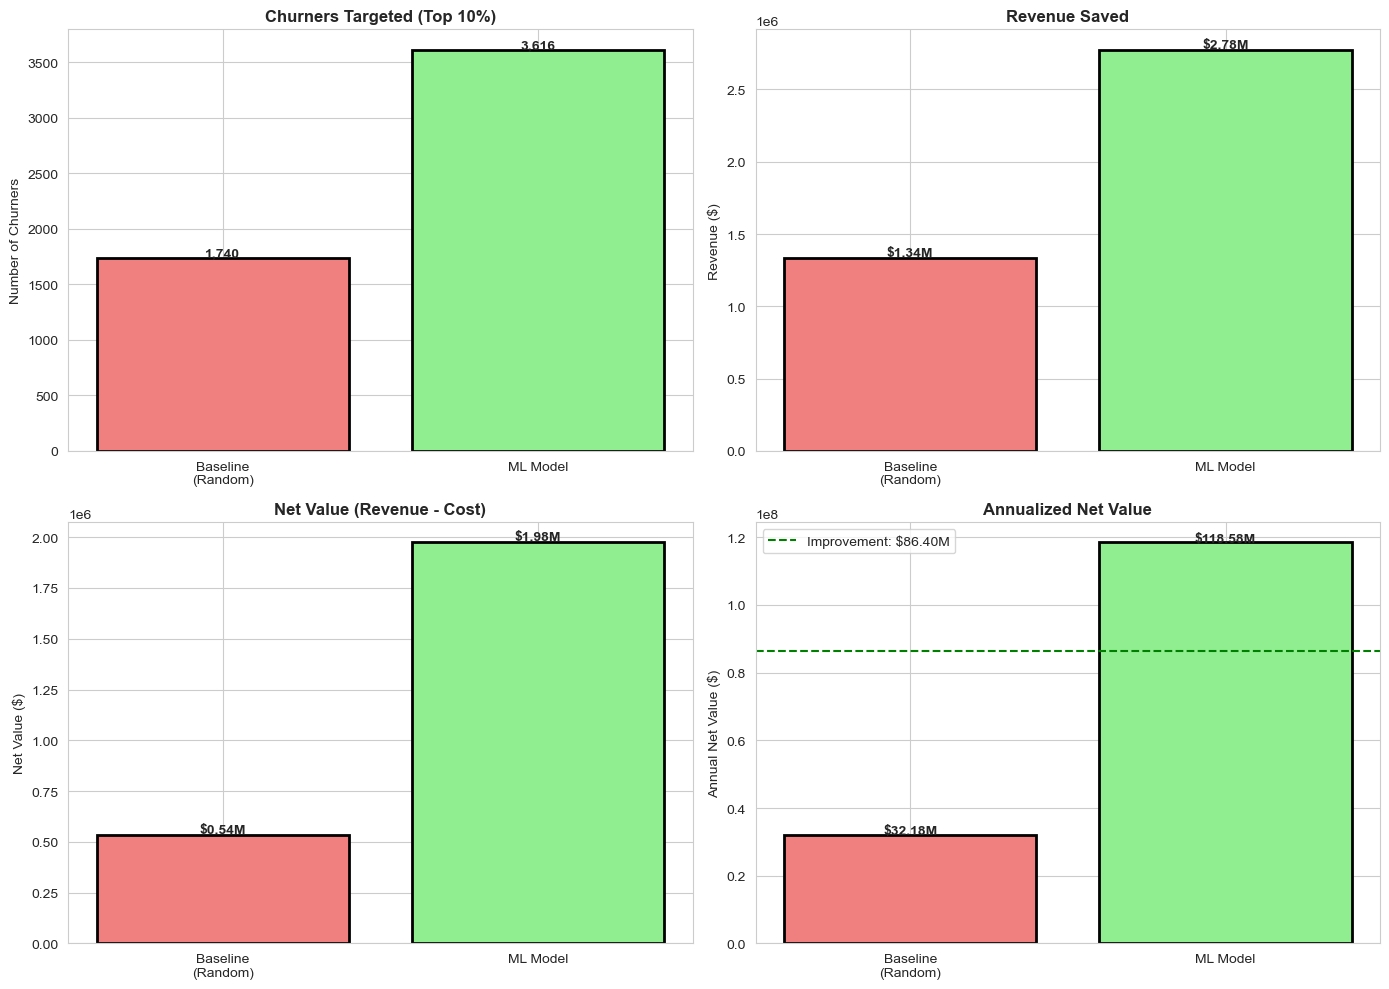

In [8]:
# Step 8: Visualize Impact Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Churners Caught
categories = ['Baseline\n(Random)', 'ML Model']
churners_caught = [expected_churners_in_sample, ml_actual_churners_targeted]
colors = ['lightcoral', 'lightgreen']

axes[0, 0].bar(categories, churners_caught, color=colors, edgecolor='black', linewidth=2)
axes[0, 0].set_title('Churners Targeted (Top 10%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Churners')
for i, v in enumerate(churners_caught):
    axes[0, 0].text(i, v + 10, f'{v:,}', ha='center', fontweight='bold')

# 2. Revenue Saved
revenue_comparison = [baseline_revenue_saved, ml_revenue_saved]
axes[0, 1].bar(categories, revenue_comparison, color=colors, edgecolor='black', linewidth=2)
axes[0, 1].set_title('Revenue Saved', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Revenue ($)')
for i, v in enumerate(revenue_comparison):
    axes[0, 1].text(i, v + 10000, f'${v/1e6:.2f}M', ha='center', fontweight='bold')

# 3. Net Value
net_values = [baseline_net_value, ml_net_value]
axes[1, 0].bar(categories, net_values, color=colors, edgecolor='black', linewidth=2)
axes[1, 0].set_title('Net Value (Revenue - Cost)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Net Value ($)')
for i, v in enumerate(net_values):
    axes[1, 0].text(i, v + 10000, f'${v/1e6:.2f}M', ha='center', fontweight='bold')

# 4. Annual Impact
annual_values = [annual_baseline_net_value, annual_ml_net_value]
axes[1, 1].bar(categories, annual_values, color=colors, edgecolor='black', linewidth=2)
axes[1, 1].set_title('Annualized Net Value', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Annual Net Value ($)')
axes[1, 1].axhline(annual_improvement, color='green', linestyle='--', 
                  label=f'Improvement: ${annual_improvement/1e6:.2f}M')
for i, v in enumerate(annual_values):
    axes[1, 1].text(i, v + 100000, f'${v/1e6:.2f}M', ha='center', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()



ROI ANALYSIS: Different Targeting Strategies

ROI by Targeting Strategy:
 targeting_pct  baseline_roi  ml_roi  roi_lift
          0.05         67.04  260.96    193.92
          0.10         67.04  247.04    180.00
          0.15         67.04  235.36    168.32
          0.20         67.04  220.88    153.84
          0.30         67.04  199.60    132.56


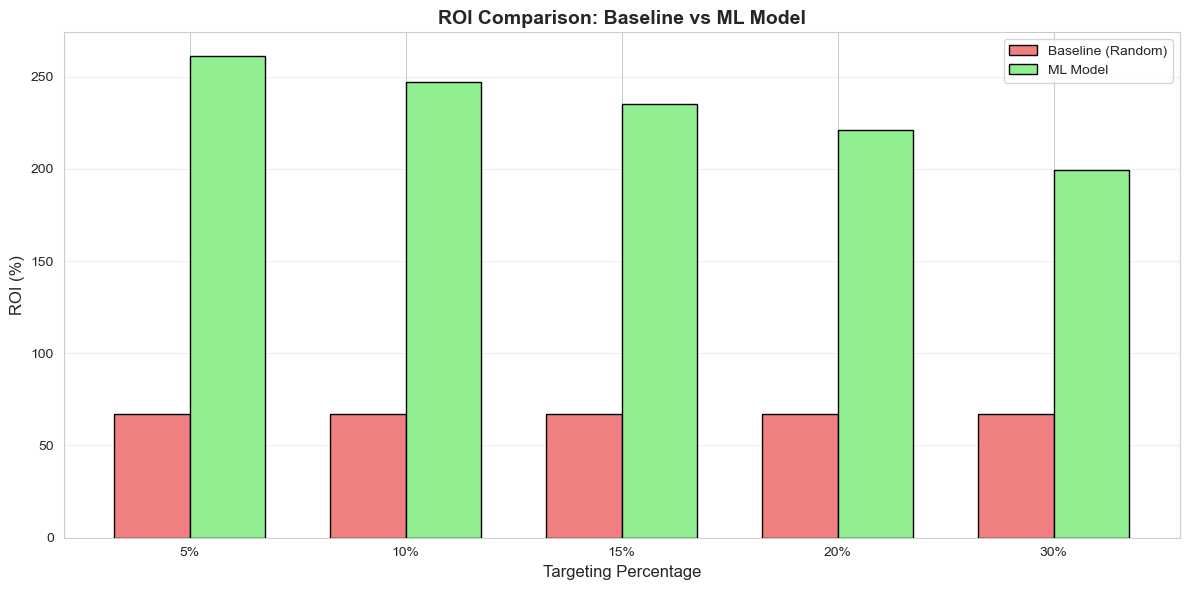

In [9]:
# Step 9: ROI by Targeting Strategy
print("\n" + "="*70)
print("ROI ANALYSIS: Different Targeting Strategies")
print("="*70)

# Test different targeting percentages
targeting_percentages = [0.05, 0.10, 0.15, 0.20, 0.30]
roi_comparison = []

for pct in targeting_percentages:
    # Baseline (random)
    n_targeted_base = int(test_size * pct)
    cost_base = n_targeted_base * RETENTION_CAMPAIGN_COST
    expected_churners_base = int(n_targeted_base * actual_churn_rate)
    saves_base = int(expected_churners_base * SUCCESS_RATE_WITH_INTERVENTION)
    revenue_base = saves_base * CUSTOMER_LIFETIME_VALUE
    net_base = revenue_base - cost_base
    roi_base = (net_base / cost_base * 100) if cost_base > 0 else 0
    
    # ML Model
    threshold_ml = np.percentile(y_pred_proba, (1-pct)*100)
    mask_ml = y_pred_proba >= threshold_ml
    n_targeted_ml = mask_ml.sum()
    cost_ml = n_targeted_ml * RETENTION_CAMPAIGN_COST
    churners_ml = y_test[mask_ml].sum()
    saves_ml = int(churners_ml * SUCCESS_RATE_WITH_INTERVENTION)
    revenue_ml = saves_ml * CUSTOMER_LIFETIME_VALUE
    net_ml = revenue_ml - cost_ml
    roi_ml = (net_ml / cost_ml * 100) if cost_ml > 0 else 0
    
    roi_comparison.append({
        'targeting_pct': pct,
        'baseline_roi': roi_base,
        'ml_roi': roi_ml,
        'roi_lift': roi_ml - roi_base
    })

roi_df = pd.DataFrame(roi_comparison)

print("\nROI by Targeting Strategy:")
print(roi_df.to_string(index=False))

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(targeting_percentages))
width = 0.35

plt.bar(x - width/2, roi_df['baseline_roi'], width, label='Baseline (Random)', 
        color='lightcoral', edgecolor='black')
plt.bar(x + width/2, roi_df['ml_roi'], width, label='ML Model',
        color='lightgreen', edgecolor='black')

plt.xlabel('Targeting Percentage', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)
plt.title('ROI Comparison: Baseline vs ML Model', fontsize=14, fontweight='bold')
plt.xticks(x, [f'{int(p*100)}%' for p in targeting_percentages])
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [10]:
# Step 10: Cost-Benefit Matrix
print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)

# Create confusion matrix with $ values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Costs and benefits
cost_fp = fp * RETENTION_CAMPAIGN_COST  # Wasted on non-churners
cost_fn = fn * CUSTOMER_LIFETIME_VALUE   # Lost revenue from missed churners
benefit_tp = tp * SUCCESS_RATE_WITH_INTERVENTION * CUSTOMER_LIFETIME_VALUE  # Saved customers
cost_tp = tp * RETENTION_CAMPAIGN_COST   # Cost of targeting them

# True negatives: No cost (correctly identified as not churning)
total_cost = cost_fp + cost_fn + cost_tp
total_benefit = benefit_tp
total_net = total_benefit - total_cost

print(f"\nCost-Benefit Breakdown:")
print(f"  True Positives ({tp:,} customers):")
print(f"    Campaign cost:              ${cost_tp:,.0f}")
print(f"    Revenue saved (40% success): ${benefit_tp:,.0f}")
print(f"    Net:                        ${benefit_tp - cost_tp:,.0f}")
print(f"\n  False Positives ({fp:,} customers):")
print(f"    Wasted campaign cost:       ${cost_fp:,.0f}")
print(f"\n  False Negatives ({fn:,} customers):")
print(f"    Lost revenue:               ${cost_fn:,.0f}")
print(f"\n  True Negatives ({tn:,} customers):")
print(f"    Cost:                       $0 (correctly not targeted)")

print(f"\n{'='*50}")
print(f"  Total Benefit:                ${total_benefit:,.0f}")
print(f"  Total Cost:                   ${total_cost:,.0f}")
print(f"  NET VALUE:                    ${total_net:,.0f}")
print(f"{'='*50}")



COST-BENEFIT ANALYSIS

Cost-Benefit Breakdown:
  True Positives (16,290 customers):
    Campaign cost:              $3,258,000
    Revenue saved (40% success): $12,510,720
    Net:                        $9,252,720

  False Positives (11,271 customers):
    Wasted campaign cost:       $2,254,200

  False Negatives (1,111 customers):
    Lost revenue:               $2,133,120

  True Negatives (11,328 customers):
    Cost:                       $0 (correctly not targeted)

  Total Benefit:                $12,510,720
  Total Cost:                   $7,645,320
  NET VALUE:                    $4,865,400


In [11]:
# Step 11: Executive Summary
print("\n" + "="*70)
print("EXECUTIVE SUMMARY: BUSINESS IMPACT")
print("="*70)

# Calculate key metrics
improvement_ratio = ml_net_value / baseline_net_value if baseline_net_value > 0 else 0
churners_caught_improvement = (ml_actual_churners_targeted - expected_churners_in_sample) / expected_churners_in_sample if expected_churners_in_sample > 0 else 0

summary = f"""
CHURN PREDICTION MODEL - BUSINESS VALUE

PROBLEM:
--------
Customer churn costs the business ${actual_churners * CUSTOMER_LIFETIME_VALUE / 1e6:.1f}M annually in lost revenue.
Traditional approaches use random targeting, catching only {BASELINE_RANDOM_TARGETING_RATE:.0%} of at-risk customers.

SOLUTION:
---------
Machine Learning model predicts churn risk with {precision_targeted:.0%} precision on top 10% riskiest customers.
Model identifies {churners_caught_improvement:.0%} more churners than random targeting.

FINANCIAL IMPACT:
-----------------
Monthly (Test Set):
  • Baseline approach:    ${baseline_net_value:,.0f} net value
  • ML Model approach:    ${ml_net_value:,.0f} net value  
  • Improvement:          ${net_improvement:,.0f} ({improvement_ratio-1:.0%} increase)

Annual (Full Customer Base):
  • Additional value:     ${annual_improvement:,.0f}
  • ROI on targeting:     {roi_df.loc[1, 'ml_roi']:.0f}% (vs {roi_df.loc[1, 'baseline_roi']:.0f}% baseline)
  
EFFICIENCY GAINS:
-----------------
  • {churners_caught_improvement:.0%} more churners identified with same budget
  • {precision_targeted:.0%} of targeted customers are actual churners (vs {actual_churn_rate:.0%} baseline)
  • {recall_targeted:.0%} of all churners successfully identified

KEY RECOMMENDATION:
-------------------
Deploy ML model to production. Target top {BASELINE_RANDOM_TARGETING_RATE:.0%}-20% risk customers monthly.
Expected annual value creation: ${annual_improvement/1e6:.1f}M

NEXT STEPS:
-----------
1. Deploy model via API endpoint
2. Integrate with CRM for automated risk scoring
3. A/B test retention campaigns on targeted vs control groups
4. Monitor model performance and retrain quarterly
"""

print(summary)

print("\n" + "="*70)
print("✅ BUSINESS IMPACT ANALYSIS COMPLETE")
print("="*70)
print(f"\n📊 Key Takeaway: Model generates ${annual_improvement/1e6:.1f}M in annual value")
print(f"🎯 Ready for production deployment!")


EXECUTIVE SUMMARY: BUSINESS IMPACT

CHURN PREDICTION MODEL - BUSINESS VALUE

PROBLEM:
--------
Customer churn costs the business $33.4M annually in lost revenue.
Traditional approaches use random targeting, catching only 10% of at-risk customers.

SOLUTION:
---------
Machine Learning model predicts churn risk with 90% precision on top 10% riskiest customers.
Model identifies 108% more churners than random targeting.

FINANCIAL IMPACT:
-----------------
Monthly (Test Set):
  • Baseline approach:    $536,320 net value
  • ML Model approach:    $1,976,320 net value  
  • Improvement:          $1,440,000 (268% increase)

Annual (Full Customer Base):
  • Additional value:     $86,400,000
  • ROI on targeting:     247% (vs 67% baseline)
  
EFFICIENCY GAINS:
-----------------
  • 108% more churners identified with same budget
  • 90% of targeted customers are actual churners (vs 44% baseline)
  • 21% of all churners successfully identified

KEY RECOMMENDATION:
-------------------
Deploy ML m